- [Lab: 9.6.1 Support Vector Classifier](#9.6.1-Support-Vector-Classifier)
- [Lab: 9.6.2 Support Vector Machine](#9.6.2-Support-Vector-Machine)
- [Lab: 9.6.3 ROC Curves](#9.6.3-ROC-Curves)
- [Lab: 9.6.4 SVM with Multiple Classes](#9.6.4-SVM-with-Multiple-Classes)
- [Lab: 9.6.5 Application to Gene Expression Data](#9.6.5-Application-to-Gene-Expression-Data)
- [Lab+: Support Vector Regression](#A1.-Support-Vector-Regression)
- [Lab+: One Class SVM for Outlier Detection](#A2.-One-Class-SVM:-Outlier-Detection)

# Chapter 9 - Support Vector Machines

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import label_binarize
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC, LinearSVC, SVR, OneClassSVM
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

pd.set_option('display.notebook_repr_html', False)
 
%matplotlib inline
plt.style.use('seaborn-white')

/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/yuany/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## LAB

### 9.6.1 Support Vector Classifier

Define a function to plot a classifier with support vectors.

In [2]:
def plot_svc(svc, X, y, h=0.02, pad=0.25):
    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)

    plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=plt.cm.Paired)
    # Support vectors indicated in plot by vertical lines
    sv = svc.support_vectors_
    plt.scatter(sv[:,0], sv[:,1], c='k', marker='|', s=100, linewidths='1')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    print('Number of support vectors: ', svc.support_.size)

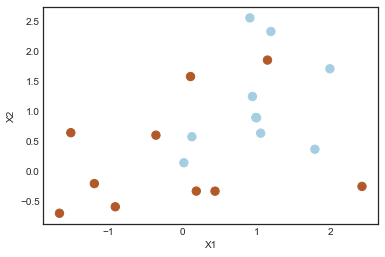

In [3]:
# Generating random data: 20 observations of 2 features and divide into two classes.
np.random.seed(5)
X = np.random.randn(20,2)
y = np.repeat([1,-1], 10)

X[y == -1] = X[y == -1] +1
plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2');

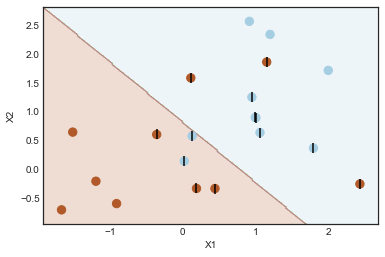

Number of support vectors:  13


In [4]:
# Support Vector Classifier with linear kernel.
svc = SVC(C= 1.0, kernel='linear')
svc.fit(X, y)

plot_svc(svc, X, y)

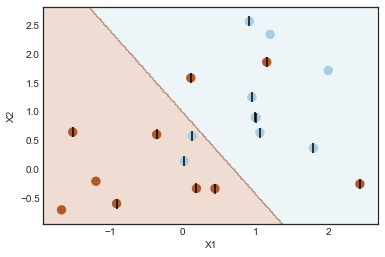

Number of support vectors:  16


In [5]:
# When using a smaller cost parameter (C=0.1) the margin is wider, resulting in more support vectors.
svc2 = SVC(C=0.1, kernel='linear')
svc2.fit(X, y)
plot_svc(svc2, X, y)

In [6]:
# Select the optimal C parameter by cross-validation
tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}]
clf = GridSearchCV(SVC(kernel='linear'), tuned_parameters, cv=10, scoring='accuracy')
clf.fit(X, y)
clf.grid_scores_

[mean: 0.80000, std: 0.24495, params: {'C': 0.001},
 mean: 0.80000, std: 0.24495, params: {'C': 0.01},
 mean: 0.80000, std: 0.24495, params: {'C': 0.1},
 mean: 0.75000, std: 0.33541, params: {'C': 1},
 mean: 0.75000, std: 0.33541, params: {'C': 5},
 mean: 0.75000, std: 0.33541, params: {'C': 10},
 mean: 0.75000, std: 0.33541, params: {'C': 100}]

In [7]:
# 0.001 is best according to GridSearchCV. 
clf.best_params_

{'C': 0.001}

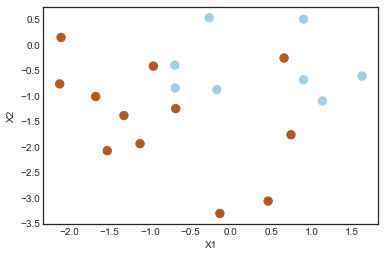

In [8]:
# Generating test data
np.random.seed(1)
X_test = np.random.randn(20,2)
y_test = np.random.choice([-1,1], 20)
X_test[y_test == 1] = X_test[y_test == 1] -1

plt.scatter(X_test[:,0], X_test[:,1], s=70, c=y_test, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2');

In [9]:
# svc2 : C = 0.1
y_pred = svc2.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred),index=svc.classes_, columns=svc.classes_)

    -1   1
-1   2   6
 1   0  12

In [10]:
svc3 = SVC(C=0.001, kernel='linear')
svc3.fit(X, y)

# svc3 : C = 0.001
y_pred = svc3.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_pred), index=svc3.classes_, columns=svc3.classes_)
# The misclassification is the same

    -1   1
-1   2   6
 1   0  12

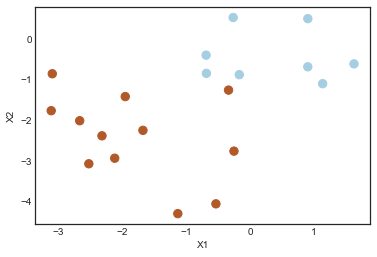

In [11]:
# Changing the test data so that the classes are really seperable with a hyperplane.
X_test[y_test == 1] = X_test[y_test == 1] -1
plt.scatter(X_test[:,0], X_test[:,1], s=70, c=y_test, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2');

In [12]:
svc4 = SVC(C=10.0, kernel='linear')
svc4.fit(X_test, y_test)

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

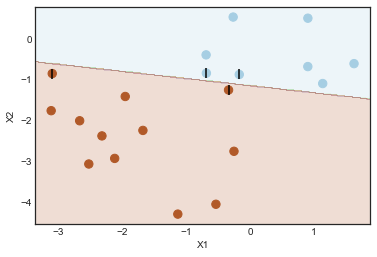

Number of support vectors:  4


In [13]:
plot_svc(svc4, X_test, y_test)

In [14]:
# Increase the margin. Now there is one misclassification: increased bias, lower variance.
svc5 = SVC(C=1, kernel='linear')
svc5.fit(X_test, y_test)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

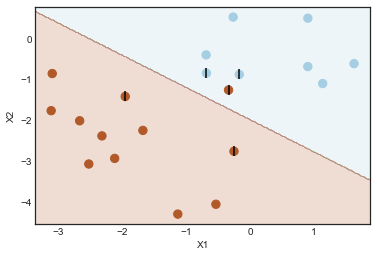

Number of support vectors:  5


In [15]:
plot_svc(svc5, X_test, y_test)

### 9.6.2 Support Vector Machine 

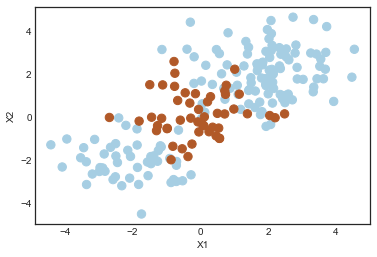

In [16]:
# Generating test data
np.random.seed(8)
X = np.random.randn(200,2)
X[:100] = X[:100] +2
X[101:150] = X[101:150] -2
y = np.concatenate([np.repeat(-1, 150), np.repeat(1,50)])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=2)

plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=plt.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2');

In [17]:
svm = SVC(C=1.0, kernel='rbf', gamma=1)
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

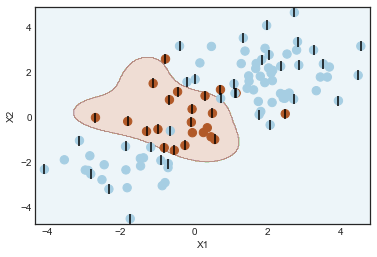

Number of support vectors:  51


In [18]:
plot_svc(svm, X_train, y_train)

In [19]:
# Increasing C parameter, allowing more flexibility
svm2 = SVC(C=100, kernel='rbf', gamma=1.0)
svm2.fit(X_train, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

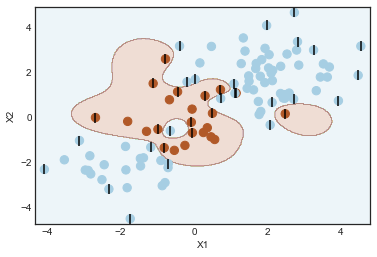

Number of support vectors:  36


In [20]:
plot_svc(svm2, X_train, y_train)

In [21]:
# Set the parameters by cross-validation
tuned_parameters = [{'C': [0.01, 0.1, 1, 10, 100],
                     'gamma': [0.5, 1,2,3,4]}]
clf = GridSearchCV(SVC(kernel='rbf'), tuned_parameters, cv=10, scoring='accuracy')
clf.fit(X_train, y_train)
clf.grid_scores_

[mean: 0.77000, std: 0.03039, params: {'C': 0.01, 'gamma': 0.5},
 mean: 0.77000, std: 0.03039, params: {'C': 0.01, 'gamma': 1},
 mean: 0.77000, std: 0.03039, params: {'C': 0.01, 'gamma': 2},
 mean: 0.77000, std: 0.03039, params: {'C': 0.01, 'gamma': 3},
 mean: 0.77000, std: 0.03039, params: {'C': 0.01, 'gamma': 4},
 mean: 0.77000, std: 0.03039, params: {'C': 0.1, 'gamma': 0.5},
 mean: 0.77000, std: 0.03039, params: {'C': 0.1, 'gamma': 1},
 mean: 0.77000, std: 0.03039, params: {'C': 0.1, 'gamma': 2},
 mean: 0.77000, std: 0.03039, params: {'C': 0.1, 'gamma': 3},
 mean: 0.77000, std: 0.03039, params: {'C': 0.1, 'gamma': 4},
 mean: 0.92000, std: 0.11024, params: {'C': 1, 'gamma': 0.5},
 mean: 0.92000, std: 0.09015, params: {'C': 1, 'gamma': 1},
 mean: 0.90000, std: 0.09046, params: {'C': 1, 'gamma': 2},
 mean: 0.88000, std: 0.07597, params: {'C': 1, 'gamma': 3},
 mean: 0.85000, std: 0.06424, params: {'C': 1, 'gamma': 4},
 mean: 0.92000, std: 0.07827, params: {'C': 10, 'gamma': 0.5},
 mean:

In [22]:
clf.best_params_

{'C': 1, 'gamma': 0.5}

In [23]:
confusion_matrix(y_test, clf.best_estimator_.predict(X_test))

array([[67,  6],
       [ 9, 18]])

In [24]:
# 15% of test observations misclassified
clf.best_estimator_.score(X_test, y_test)

0.84999999999999998

### 9.6.3 ROC Curves

Comparing the ROC curves of two models on train/test data. One model is more flexible than the other.

In [25]:
svm3 = SVC(C=1, kernel='rbf', gamma=2)
svm3.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [26]:
# More flexible model
svm4 = SVC(C=1, kernel='rbf', gamma=50)
svm4.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=50, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

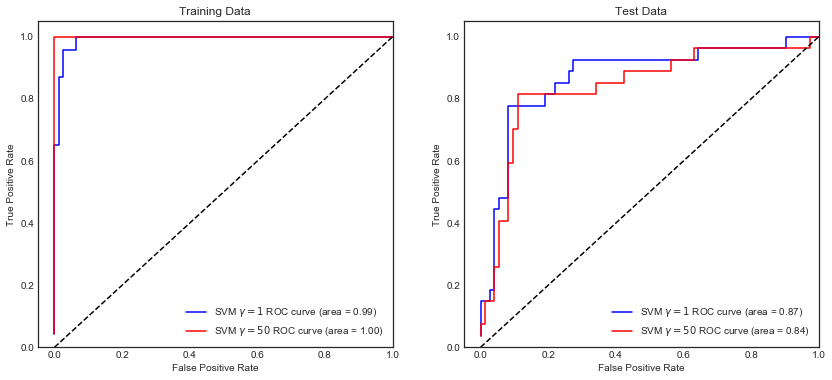

In [27]:
y_train_score3 = svm3.decision_function(X_train)
y_train_score4 = svm4.decision_function(X_train)

false_pos_rate3, true_pos_rate3, _ = roc_curve(y_train, y_train_score3)
roc_auc3 = auc(false_pos_rate3, true_pos_rate3)

false_pos_rate4, true_pos_rate4, _ = roc_curve(y_train, y_train_score4)
roc_auc4 = auc(false_pos_rate4, true_pos_rate4)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.plot(false_pos_rate3, true_pos_rate3, label='SVM $\gamma = 1$ ROC curve (area = %0.2f)' % roc_auc3, color='b')
ax1.plot(false_pos_rate4, true_pos_rate4, label='SVM $\gamma = 50$ ROC curve (area = %0.2f)' % roc_auc4, color='r')
ax1.set_title('Training Data')

y_test_score3 = svm3.decision_function(X_test)
y_test_score4 = svm4.decision_function(X_test)

false_pos_rate3, true_pos_rate3, _ = roc_curve(y_test, y_test_score3)
roc_auc3 = auc(false_pos_rate3, true_pos_rate3)

false_pos_rate4, true_pos_rate4, _ = roc_curve(y_test, y_test_score4)
roc_auc4 = auc(false_pos_rate4, true_pos_rate4)

ax2.plot(false_pos_rate3, true_pos_rate3, label='SVM $\gamma = 1$ ROC curve (area = %0.2f)' % roc_auc3, color='b')
ax2.plot(false_pos_rate4, true_pos_rate4, label='SVM $\gamma = 50$ ROC curve (area = %0.2f)' % roc_auc4, color='r')
ax2.set_title('Test Data')

for ax in fig.axes:
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

As expected, the more flexible model scores better on training data but worse on the test data.

### 9.6.4 SVM with Multiple Classes

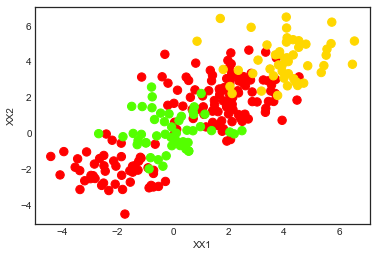

In [28]:
# Adding a third class of observations
np.random.seed(8)
XX = np.vstack([X, np.random.randn(50,2)])
yy = np.hstack([y, np.repeat(0,50)])
XX[yy ==0] = XX[yy == 0] +4

plt.scatter(XX[:,0], XX[:,1], s=70, c=yy, cmap=plt.cm.prism)
plt.xlabel('XX1')
plt.ylabel('XX2');

In [29]:
svm5 = SVC(C=1, kernel='rbf')
svm5.fit(XX, yy)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

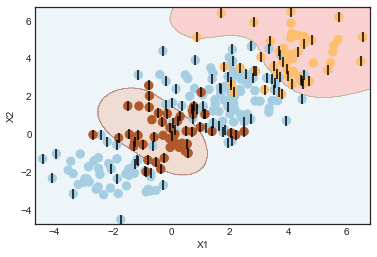

Number of support vectors:  133


In [30]:
plot_svc(svm5, XX, yy)

### 9.6.5 Application to Gene Expression Data

In R, I exported the dataset from package 'ISLR' to csv files.

In [31]:
X_train = pd.read_csv('Data/Khan_xtrain.csv').drop('Unnamed: 0', axis=1)
y_train = pd.read_csv('Data/Khan_ytrain.csv').drop('Unnamed: 0', axis=1).as_matrix().ravel()
X_test = pd.read_csv('Data/Khan_xtest.csv').drop('Unnamed: 0', axis=1)
y_test = pd.read_csv('Data/Khan_ytest.csv').drop('Unnamed: 0', axis=1).as_matrix().ravel()

In [32]:
# y_train counts
pd.Series(y_train).value_counts(sort=False)

1     8
2    23
3    12
4    20
dtype: int64

In [33]:
# y_test counts
pd.Series(y_test).value_counts(sort=False)

1    3
2    6
3    6
4    5
dtype: int64

In [34]:
# This model gives identical results to the svm() of the R package e1071, also based on libsvm library.
svc = SVC(kernel='linear')

# This model is based on liblinear library and gives 100 score on the test data. 
#svc = LinearSVC()

svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [35]:
cm = confusion_matrix(y_train, svc.predict(X_train))
cm_df = pd.DataFrame(cm.T, index=svc.classes_, columns=svc.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True       1   2   3   4
Predicted               
1          8   0   0   0
2          0  23   0   0
3          0   0  12   0
4          0   0   0  20


In [36]:
cm = confusion_matrix(y_test, svc.predict(X_test))
cm_df = pd.DataFrame(cm.T, index=svc.classes_, columns=svc.classes_)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

True       1  2  3  4
Predicted            
1          3  0  0  0
2          0  6  2  0
3          0  0  4  0
4          0  0  0  5


### A1. Support Vector Regression

In [37]:
# #############################################################################
# Generate sample data
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

# #############################################################################
# Add noise to targets
y[::5] += 3 * (0.5 - np.random.rand(8))


In [38]:
# #############################################################################
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

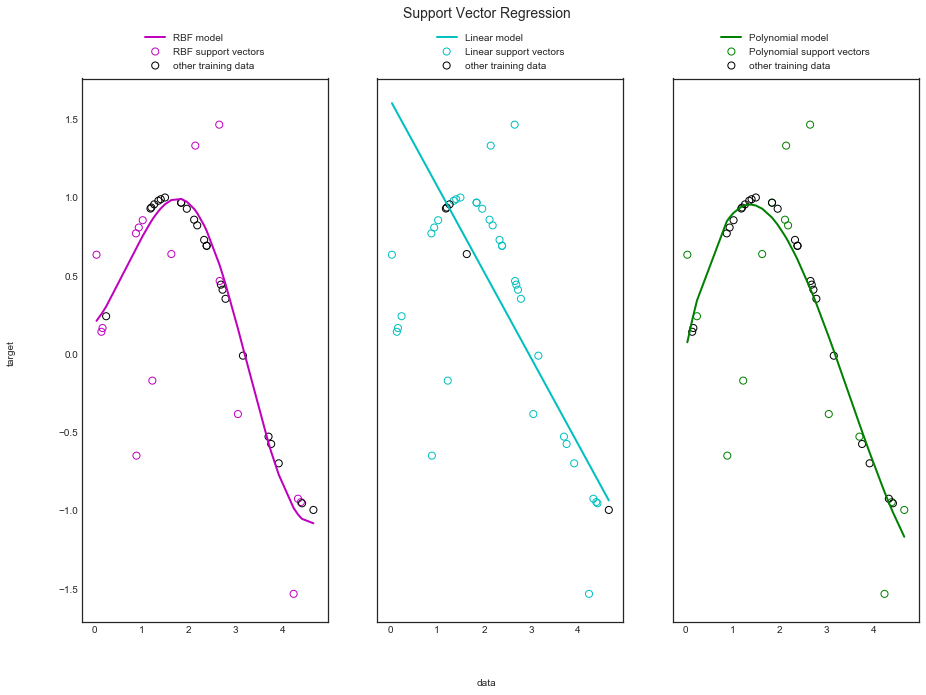

In [39]:
# #############################################################################
# Look at the results
lw = 2

svrs = [svr_rbf, svr_lin, svr_poly]
kernel_label = ['RBF', 'Linear', 'Polynomial']
model_color = ['m', 'c', 'g']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    axes[ix].plot(X, svr.fit(X, y).predict(X), color=model_color[ix], lw=lw,
                  label='{} model'.format(kernel_label[ix]))
    axes[ix].scatter(X[svr.support_], y[svr.support_], facecolor="none",
                     edgecolor=model_color[ix], s=50,
                     label='{} support vectors'.format(kernel_label[ix]))
    axes[ix].scatter(X[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     y[np.setdiff1d(np.arange(len(X)), svr.support_)],
                     facecolor="none", edgecolor="k", s=50,
                     label='other training data')
    axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'data', ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

### A2. One Class SVM: Outlier Detection

In [40]:
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import time
import matplotlib

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

In [41]:
# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

In [42]:
# define outlier/anomaly detection methods to be compared
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", OneClassSVM(nu=outliers_fraction, kernel="rbf",
                                      gamma=0.1)),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction,
                                         random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(
        n_neighbors=35, contamination=outliers_fraction))]

In [43]:
# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3],
               **blobs_params)[0],
    4. * (make_moons(n_samples=n_samples, noise=.05, random_state=0)[0] -
          np.array([0.5, 0.25])),
    14. * (np.random.RandomState(42).rand(n_samples, 2) - 0.5)]

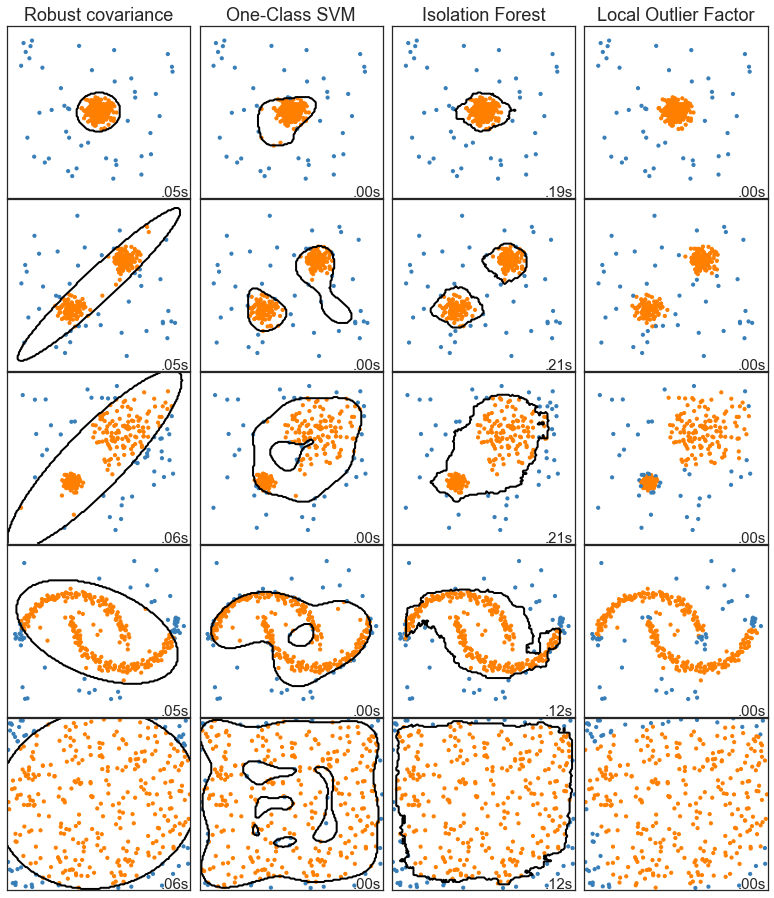

In [44]:
# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150),
                     np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6,
                       size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()